In [1]:
import numpy as np
import scipy.constants as spc

class DeviceStructure:
    def __init__(
        self,
        length=100e-9,
        width=40e-9,
        thickness=8e-9,
        Na_bulk=5.0e24,
        Nd_bulk=1.0e23,
        transition_ratio=0.05,
        bias_points=21,
        bias_min=-0.5,
        bias_max=0.5,
    ):
        # Physical constants
        self.T = 300
        self.kbT = spc.Boltzmann * self.T
        self.q = spc.e
        self.hbar = spc.hbar
        self.m = 0.45 * spc.m_e
        self.epsl = 8.854e-12 * 11.7  # Silicon permittivity
        self.Eg = 1.12 * spc.e  # Band gap (J)

        # Geometry (realistic nanowire cross-section)
        self.a = 2.5e-10  # lattice spacing (m)
        self.length = float(length)
        self.width = float(width)
        self.thickness = float(thickness)
        self.area = self.width * self.thickness  # cross-sectional area (m^2)
        self.V_S = 0.0
        self.V_D = 0.0

        # Discretisation
        self.Nx = int(np.ceil(self.length / self.a))
        self.x = np.linspace(0.0, (self.Nx - 1) * self.a, self.Nx)
        self.junction_index = self.Nx // 2

        # Density-of-states factors
        self.n2d = (2.0 * self.m * self.kbT) / (self.hbar**2 * np.pi * 2.0)
        self.n1d = 2.0 * np.sqrt(self.m * self.kbT / (self.hbar**2 * np.pi * 2.0))
        self.Nc_3d = 2.0 * ((2.0 * np.pi * self.m * self.kbT) / (spc.h**2)) ** 1.5
        self.Nv_3d = self.Nc_3d
        self.Nc = self.Nc_3d * self.area  # convert to 1-D concentration (m^-1)
        self.Nv = self.Nv_3d * self.area
        self.ni_3d = np.sqrt(self.Nc_3d * self.Nv_3d) * np.exp(-self.Eg / (2.0 * self.kbT))
        self.ni = self.ni_3d * self.area

        # Tight-binding parameters
        self.t0 = self.hbar**2 / (2.0 * self.m * self.a**2 * self.q)
        self.H00 = np.array([[2.0 * self.t0]])
        self.H10 = np.array([[-self.t0]])
        self.orbitals = 1

        # Doping profile: asymmetric P+ / N junction with smooth transition
        self.Na_bulk = float(Na_bulk)
        self.Nd_bulk = float(Nd_bulk)
        self.transition_ratio = float(transition_ratio)
        junction_index = self.junction_index
        site_index = np.arange(self.Nx)
        transition = max(1.0, self.transition_ratio * self.Nx)
        left_fraction = 0.5 * (1.0 + np.tanh((junction_index - site_index) / transition))
        right_fraction = 1.0 - left_fraction
        self.Na = self.Na_bulk * self.area  # convert to 1-D concentration (m^-1)
        self.Nd = self.Nd_bulk * self.area
        self.NB = right_fraction * self.Nd - left_fraction * self.Na

        # Intrinsic carrier concentration and built-in potential
        self.ni = np.sqrt(self.Nc * self.Nv) * np.exp(-self.Eg / (2.0 * self.kbT))
        self.phi_bi = (self.kbT / self.q) * np.log((self.Na * self.Nd) / (self.ni**2 + 1e-30))
        self.phi_left = 0.0

        # Bias sweep
        self.bias_points = int(bias_points)
        self.bias_min = float(bias_min)
        self.bias_max = float(bias_max)
        self.Vds = np.linspace(self.bias_min, self.bias_max, self.bias_points)
        self.Vgs = np.array([0.0])  # retained for legacy tensor shapes

        # Storage
        VV = len(self.Vds)
        self.II = np.zeros((VV, self.Vgs.size))
        self.nn = np.zeros((VV, self.Vgs.size, self.Nx))
        self.pp = np.zeros((VV, self.Vgs.size, self.Nx))
        self.nn_poisson = np.zeros_like(self.nn)
        self.pp_poisson = np.zeros_like(self.pp)
        self.EEc = np.zeros((VV, self.Vgs.size, self.Nx))
        self.EFn = np.zeros((VV, self.Vgs.size, self.Nx))
        self.EFp = np.zeros((VV, self.Vgs.size, self.Nx))

In [2]:
class Helper_functions:
    
    # Define F_1/2(x)
    def FD_half(x):
        '''
        Approximation of the Fermi-Dirac integral of order 1/2.
        Reference: http://dx.doi.org/10.1063/1.4825209
        '''
        x = np.asarray(x, dtype=float)
        v = x**4 + 50 + 33.6 * x * (1 - 0.68 * np.exp(-0.17 * (x + 1)**2))
        return 1 / (np.exp(-x) + 3 * np.pi**0.5 / 4 * v**(-3/8))

    # Define F_-1/2(x) as the derivative of F_1/2(x)
    def FD_minus_half(x):
        x = np.asarray(x, dtype=float)
        dx = np.where(np.abs(x) > 1e-3, np.abs(x) * 1e-6, 1e-9)
        return (Helper_functions.FD_half(x + dx) - Helper_functions.FD_half(x - dx)) / (2 * dx)

    def sparse_diag_product(A, B):
        """
        Compute diagonal elements of C = A * B efficiently for sparse matrices.

        Parameters:
            A (csr_matrix): sparse matrix in CSR format
            B (csc_matrix): sparse matrix in CSC format

        Returns:
            numpy.ndarray: diagonal elements of A*B
        """
        from scipy.sparse import csr_matrix, csc_matrix
        import numpy as np

        # Ensure A is CSR and B is CSC for efficient indexing
        if not isinstance(A, csr_matrix):
            A = csr_matrix(A)
        if not isinstance(B, csc_matrix):
            B = csc_matrix(B)

        n = A.shape[0]
        diag = np.zeros(n, dtype=complex)

        for i in range(n):
            # Get row i from A (CSR format)
            A_row_start, A_row_end = A.indptr[i], A.indptr[i+1]
            A_cols = A.indices[A_row_start:A_row_end]
            A_vals = A.data[A_row_start:A_row_end]

            # Get column i from B (CSC format)
    
            B_rows = B.indices[B.indptr[i]:B.indptr[i+1]]
            B_vals = B.data[B.indptr[i]:B.indptr[i+1]]

            # Compute intersection of indices efficiently
            ptr_a, ptr_b = 0, 0
            sum_diagonal = 0.0
            while ptr_a < len(A_cols) and ptr_b < len(B_rows):
                col_a, row_b = A_cols[ptr_a], B_rows[ptr_b]
                if col_a == row_b:
                    sum_diagonal += A_vals[ptr_a] * B_vals[ptr_b]
                    ptr_a += 1
                    ptr_b += 1
                elif col_a < row_b:
                    ptr_a += 1
                else:
                    ptr_b += 1

            diag[i] = sum_diagonal

        return diag




In [3]:
# Hamiltonian.py
import numpy as np

class Hamiltonian:
    def __init__(self, device_state):
        self.device_state = device_state

    def create_hamiltonians(self, Ec):
        t0 = self.device_state.t0
        Nx = self.device_state.Nx
        D2 = -2.0 * np.eye(Nx) + np.eye(Nx, k=1) + np.eye(Nx, k=-1)

        H_e = -t0 * D2 + np.diag(Ec / self.device_state.q)
        Ev = Ec - self.device_state.Eg
        H_h = -t0 * D2 + np.diag(Ev / self.device_state.q)

        self.device_state.H = H_e
        self.device_state.H_e = H_e
        self.device_state.H_h = H_h
        return H_e, H_h

    def create_hamiltonian(self, Ec):
        H_e, _ = self.create_hamiltonians(Ec)
        return H_e

    def print_hamiltonian(self):
        t0 = self.device_state.t0
        Nx = self.device_state.Nx
        D2 = -2.0 * np.eye(Nx) + np.eye(Nx, k=1) + np.eye(Nx, k=-1)

        H = -t0 * D2
        self.device_state.H = H
        self.device_state.H_e = H
        return H

In [4]:
import numpy as np

class GreensFunction:
    def __init__(self, device_state):
        self.ds=device_state
        self.eta = 1e-12j
    
    def compute_GF(self,E,H,t0,Ec,Vds): # old way of doing rgf (analytic solution)
        
        Nx=self.ds.Nx; q=self.ds.q; hbar=self.ds.hbar; a=self.ds.a
        
        zplus=1j*1e-12
        
        ka1=np.arccos(1-(E+zplus-Ec[0]/q)/(2*t0))
        ka2=np.arccos(1-(E+zplus-Ec[-1]/q)/(2*t0))
        
        sig1=np.zeros((Nx,Nx),dtype=complex); sig1[0,0]=-t0*np.exp(1j*ka1); gam1=1j*(sig1-sig1.conj().T)
        
        sig2=np.zeros((Nx,Nx),dtype=complex); sig2[-1,-1]=-t0*np.exp(1j*ka2); gam2=1j*(sig2-sig2.conj().T)
        
        G=np.linalg.inv((E+zplus)*np.eye(Nx)-H-sig1-sig2)
        A = (E+zplus)*np.eye(Nx)-H-sig1-sig2
       
        #print(sig1, sig2)
        return G,gam1,gam2,sig1,sig2
    
    def rgf(self, E, Ec): #recursive solution based on the 
        E = E + self.eta
        ds = self.ds
        H = ds.H
        dagger = lambda A: np.conjugate(A.T)
        f_s = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - ds.V_S) / (ds.kbT))
        f_d = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - ds.V_D) / (ds.kbT))
        fermi = lambda x,y: 1 / (1 + np.exp((x-y) / (ds.kbT  /ds.q)))
        
        sigmaL,sigmaR = self.self_energy(E,Ec)
        
        self_energy_right = np.zeros_like(H, dtype=complex)
        self_energy_left = np.zeros_like(H, dtype=complex)
        
        self_energy_size = sigmaR.shape[0]
        self_energy_right[-self_energy_size:,-self_energy_size:] = sigmaR
        self_energy_left[0:self_energy_size,0:self_energy_size] = sigmaL
        
        
        gamma1 = 1j * (self_energy_left - dagger(self_energy_left))
        gamma2 = 1j * (self_energy_right - dagger(self_energy_right))
        self_energy_lesser = gamma1 * f_s +  gamma2 * f_d
        
        sigma_less_left = gamma1 * f_s
        sigma_less_right = gamma2 * f_d
        block_size = ds.orbitals
        print(self_energy_left[0,0], self_energy_right[-1,-1])
  
        
        
        N = H.shape[0]
        num_blocks = N // block_size
        
        E_matrix = np.eye(N, dtype=complex) * (E)
        A = E_matrix - H - self_energy_left - self_energy_right
        
        
        # Initialize arrays (this style of storing data was taken from jiezi program)
        g_R_blocks = []
        g_lesser_blocks = []

        
        G_R = [None] * num_blocks
        G_R_1 = [None] * (num_blocks - 1)
        G_lesser = [None] * num_blocks
        G_lesser_1 = [None] * (num_blocks - 1)
        
        # Forward recursion: Calculate diagonal blocks of g_R
        for i in range(num_blocks):
            start = i * block_size
            end = (i+1) * block_size
            prev = (i - 1) * block_size
            if i == 0:
                # First block
                g_0_r = np.linalg.inv(A[start:end, start:end])
                g_R_blocks.append(g_0_r)
                #g_lesser
                g_0_lesser = g_0_r @ self_energy_lesser[start:end, start:end] @ dagger(g_0_r)
                g_lesser_blocks.append(g_0_lesser)
            else:          
                
                H_eff = A[start:end, start:end] - A[start:end, prev:start] @ g_R_blocks[i-1] @ A[prev:start, start:end]
                g_R_blocks.append(np.linalg.inv(H_eff))

                #g_i_lesser calculation
                sigma_lesser = A[start:end, prev:start] @ g_lesser_blocks[i - 1] @ dagger(A[prev:start, start:end])
                g_i_lesser = g_R_blocks[i] @ (self_energy_lesser[start: end, start: end] + sigma_lesser - \
                    self_energy_lesser[start:end, prev:start] @ dagger(g_R_blocks[i - 1]) @ dagger(A[prev:start, start:end]) - \
                        A[start:end, prev:start] @ g_R_blocks[i-1] @ self_energy_lesser[prev:start, start:end]) @ dagger(g_R_blocks[i])
                g_lesser_blocks.append(g_i_lesser)        

        G_R[-1] = g_R_blocks[-1]
        G_lesser[-1] = g_lesser_blocks[-1]

        for i in reversed(range(num_blocks - 1)):
            start = i * block_size
            end = (i+1)*block_size
            after = (i+2)*block_size

            
            # Dyson equation for current block
            G_R[i] = g_R_blocks[i] @ (np.eye(block_size) + 
            A[start:end, end:after]@G_R[i+1]@A[end:after, start:end]@g_R_blocks[i])
            
            G_R_1[i] = -G_R[i + 1] @ A[end:after, start:end] @ g_R_blocks[i]
            
        
            #lesser function
            
            gr0 = np.linalg.inv(E * np.eye(block_size) - H[start:end, start:end]) 
            ga0 = dagger(gr0)
            gr1 = np.linalg.inv(E * np.eye(block_size) - H[end:after, end:after])
            ga1 = dagger(gr1)
            gqq1 = gr0 @ self_energy_lesser[start:end, end:after] @ ga1
            gq1q = gr1 @ self_energy_lesser[end:after, start:end] @ ga0 
            
            G_i_lesser = g_lesser_blocks[i] + g_R_blocks[i] @ (A[start:end, end:after] @ G_lesser[i + 1] @ dagger(A[end:after, start:end])) @ dagger(g_R_blocks[i]) - \
                (g_lesser_blocks[i] @ A[end:after, start:end] @ dagger(G_R_1[i].T) + G_R_1[i].T @ A[end:after, start:end] @ g_lesser_blocks[i]) - \
                    (gqq1 @ dagger(A[end:after, start:end]) @ dagger(G_R[i]) + G_R[i] @ A[start:end, end:after] @ gq1q)
            
            G_lesser[i] = G_i_lesser
            
            G_i_lesser_1 = gq1q - G_R_1[i] @ A[start:end, end:after] @ gq1q - G_R[i+1] @ A[end:after,start:end] @ g_lesser_blocks[i] - \
                G_lesser[i+1] @ dagger(A[end:after,start:end]) @ dagger(g_R_blocks[i])
            
            G_lesser_1[i] = G_i_lesser_1[0]
            
            
        G_R = np.diag(np.ravel(G_R).flatten())
        G_lesser = np.diag(np.ravel(G_lesser).flatten())
    
        return G_R, G_lesser, gamma1, gamma2, sigma_less_left, sigma_less_right
    
    
        """diagonals = [np.diag(block) for block in G_lesser]  # Extract diagonals 
        G_lesser = np.concatenate(diagonals, dtype=complex)  # Concatenate all diagonals 

        diagonals = [np.diag(block) for block in G_R]  # Extract diagonals 
        G_R = np.concatenate(diagonals, dtype=complex)  # Concatenate all diagonals 
        
        return G_R, G_lesser, gamma1, gamma2, sigma_less_left, sigma_less_right"""
    
    def surface_gf(self, Energy, tol=1e-6): #right now this is only tested for 1D
        device_state = self.ds
        Energy = Energy
        H00 = device_state.H00
        H10 = device_state.H10
        dagger = lambda A: np.conjugate(A.T)
        I = np.eye(H00.shape[0], dtype=complex)
        H01 = dagger(H10)

        epsilon_s = H00.copy()
        epsilon = H00.copy()
        alpha = H01.copy()
        beta = dagger(H10).copy()
        err = 1.0

        while err > tol:
            inv_E = np.linalg.inv(Energy * I - epsilon)
            epsilon_s_new = epsilon_s + alpha @ inv_E @ beta
            epsilon_new = epsilon + beta @ inv_E @ alpha + alpha @ inv_E @ beta
            alpha_new = alpha @ inv_E @ alpha
            beta_new = beta @ inv_E @ beta

            err = np.linalg.norm(alpha_new, ord='fro')

            epsilon_s, epsilon, alpha, beta = epsilon_s_new, epsilon_new, alpha_new, beta_new

        return np.linalg.inv(Energy * I - epsilon_s)
    def self_energy(self, E, Ec):
        dagger = lambda A: A.conj().T
        
        # Surface Green's functions at left and right leads
        
        G_surf_left = self.surface_gf(E - Ec[0] / self.ds.q)
        G_surf_right = self.surface_gf(E - Ec[-1] / self.ds.q)

        # Coupling matrices
        H10 = self.ds.H10
        H01 = dagger(H10)
        
        # Self-energy calculation (Σ = τ g τ†)
        sigma_left = H01 @ G_surf_left @ H10
        sigma_right = H10 @ G_surf_right @ H01
        #print(sigma_left, sigma_right)
        return sigma_left, sigma_right


In [5]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import mesh

from solver import DirichletBCSpec, NonlinearPoissonSolver, VACUUM_PERMITTIVITY

class PoissonSolver:
    """
    FEM Poisson wrapper for the 1-D PN junction including electrons and holes.
    """

    def __init__(self, device_state):
        self.ds = device_state
        self._comm = MPI.COMM_SELF
        length = (self.ds.Nx - 1) * self.ds.a
        self._domain = mesh.create_interval(self._comm, self.ds.Nx - 1, [0.0, length])
        eps_r = self.ds.epsl / VACUUM_PERMITTIVITY

        self._solver = NonlinearPoissonSolver(
            domain=self._domain,
            permittivity=eps_r,
            dirichlet_bcs=[
                DirichletBCSpec(value=lambda X: np.full(X.shape[1], 0.0), marker=self._left_boundary),
                DirichletBCSpec(value=lambda X: np.full(X.shape[1], 0.0), marker=self._right_boundary),
            ],
            degree=1,
            eps0=VACUUM_PERMITTIVITY,
        )

        dof_coords = self._solver._dof_coords[:, 0]
        dof_index = np.rint(dof_coords / self.ds.a).astype(int)
        self._dof_index = np.clip(dof_index, 0, self.ds.Nx - 1)
        self._nb_dof = self.ds.NB[self._dof_index].copy()
        self._cross_section = max(self.ds.area, 1e-30)
        self._charge_scale = self.ds.q / self._cross_section
        self._last_phi: np.ndarray | None = None

        self._laplacian = self._build_fd_operator()
        self.fd_residual_history: list[float] = []

    def _left_boundary(self, x):
        return np.isclose(x[0], 0.0)

    def _right_boundary(self, x):
        return np.isclose(x[0], (self.ds.Nx - 1) * self.ds.a)

    def _update_boundary_conditions(self, Vd):
        phi_left = self.ds.phi_left
        phi_right = self.ds.phi_bi - Vd
        self._solver._bc_functions[0].x.array.fill(phi_left)
        self._solver._bc_functions[1].x.array.fill(phi_right)
        for fn in self._solver._bc_functions:
            fn.x.scatter_forward()
        return phi_left, phi_right

    def fermi_dirac(self, eta):
        eta = np.asarray(eta, dtype=float)
        return np.log1p(np.exp(-np.abs(eta))) + np.maximum(eta, 0.0)

    def _carrier_density(self, eta):
        return self.ds.Nc * self.fermi_dirac(eta)

    def _hole_density(self, eta):
        return self.ds.Nv * self.fermi_dirac(eta)

    def _make_charge_callback(self, Efn_dof, Efp_dof):
        kbT = self.ds.kbT
        Eg = self.ds.Eg
        nb_dof = self._nb_dof
        scale = self._charge_scale

        def charge_callback(potential, coords):
            phi = potential
            Ec = -self.ds.q * phi
            Ev = Ec - Eg
            eta_n = (Efn_dof - Ec) / kbT
            eta_p = (Ev - Efp_dof) / kbT
            n0 = self._carrier_density(eta_n)
            p0 = self._hole_density(eta_p)
            rho = scale * (p0 - n0 + nb_dof)
            return rho

        return charge_callback

    def solve_poisson(self, Vd, Efn, Efp):
        Efn = np.asarray(Efn, dtype=float)
        Efp = np.asarray(Efp, dtype=float)

        phi_left, phi_right = self._update_boundary_conditions(Vd)

        Efn_dof = Efn[self._dof_index]
        Efp_dof = Efp[self._dof_index]
        self._solver.set_charge_callback(self._make_charge_callback(Efn_dof, Efp_dof))

        if self._last_phi is None:
            initial_phi = np.linspace(phi_left, phi_right, self._solver.solution.x.array.size)
        else:
            initial_phi = self._last_phi

        result = self._solver.solve(initial_guess=initial_phi)
        phi = result.potential.x.array.copy()
        self._last_phi = phi

        Ec = -self.ds.q * phi
        Ev = Ec - self.ds.Eg
        eta_n = (Efn - Ec) / self.ds.kbT
        eta_p = (Ev - Efp) / self.ds.kbT
        n0 = self._carrier_density(eta_n)
        p0 = self._hole_density(eta_p)

        self._record_fd_residual(Ec, n0, p0)
        return Ec, n0, p0

    def _record_fd_residual(self, Ec, n0, p0):
        phi = -Ec / self.ds.q
        laplacian = (self._laplacian @ phi) / (self.ds.a**2)
        rho_line = p0 - n0 + self.ds.NB
        rho_vol = self._charge_scale * rho_line
        residual = self.ds.epsl * laplacian + rho_vol
        max_res = float(np.max(np.abs(residual)))
        self.fd_residual_history.append(max_res)

    def _build_fd_operator(self):
        Nx = self.ds.Nx
        D2 = -2.0 * np.eye(Nx)
        idx = np.arange(Nx - 1)
        D2[idx, idx + 1] = 1.0
        D2[idx + 1, idx] = 1.0
        D2[0, 0] = -1.0
        D2[-1, -1] = -1.0
        return D2

In [6]:
import numpy as np
import matplotlib.pyplot as plt


class MainSolver:
    def __init__(self, device_kwargs=None):
        device_kwargs = {} if device_kwargs is None else dict(device_kwargs)
        self.ds = DeviceStructure(**device_kwargs)
        self.ham = Hamiltonian(self.ds)
        self.gf = GreensFunction(self.ds)
        self.ps = PoissonSolver(self.ds)
        self.RGF = False
        self.device_kwargs = device_kwargs

    def _initial_quasi_fermi_levels(self):
        ds = self.ds
        phi_initial = np.linspace(ds.phi_left, ds.phi_bi, ds.Nx)
        Ec = -ds.q * phi_initial
        Ev = Ec - ds.Eg
        Nd = np.clip(ds.NB, 0.0, None)
        Na = np.clip(-ds.NB, 0.0, None)
        n_target = np.where(ds.NB > 0.0, Nd, np.where(ds.NB < 0.0, (ds.ni**2) / (Na + 1e-30), ds.ni))
        p_target = np.where(ds.NB < 0.0, Na, np.where(ds.NB > 0.0, (ds.ni**2) / (Nd + 1e-30), ds.ni))
        n_target = np.maximum(n_target, 1e-30)
        p_target = np.maximum(p_target, 1e-30)
        Efn = Ec + ds.kbT * np.log(n_target / ds.Nc)
        Efp = Ev - ds.kbT * np.log(p_target / ds.Nv)
        ds.Efn_contact_left = float(Efn[0])
        ds.Efn_contact_right = float(Efn[-1])
        ds.Efp_contact_left = float(Efp[0])
        ds.Efp_contact_right = float(Efp[-1])
        return Ec, Efn, Efp

    def solve(self):
        ds = self.ds
        num_bias = len(ds.Vds)
        num_gate = len(ds.Vgs)
        ds.II = np.zeros((num_bias, num_gate))
        ds.nn = np.zeros((num_bias, num_gate, ds.Nx))
        ds.pp = np.zeros((num_bias, num_gate, ds.Nx))
        ds.nn_poisson = np.zeros((num_bias, num_gate, ds.Nx))
        ds.pp_poisson = np.zeros((num_bias, num_gate, ds.Nx))
        ds.EEc = np.zeros((num_bias, num_gate, ds.Nx))
        ds.EFn = np.zeros((num_bias, num_gate, ds.Nx))
        ds.EFp = np.zeros((num_bias, num_gate, ds.Nx))

        Ec, Efn, Efp = self._initial_quasi_fermi_levels()
        contact_pts = max(3, ds.Nx // 40)

        for i, Vd in enumerate(ds.Vds):
            print(f"Solving for Vd={Vd:.3f} V")
            ds.V_S = 0.0
            ds.V_D = -Vd

            error_current = 1.0
            max_iter = 100
            iteration = 0
            I_total_prev = 0.0
            n_tot = np.zeros(ds.Nx)
            p_tot = np.zeros(ds.Nx)

            while error_current > 1e-3 and iteration < max_iter:
                Efn_bc = Efn.copy()
                Efp_bc = Efp.copy()
                Efn_left = ds.Efn_contact_left
                Efn_right = ds.Efn_contact_right - ds.q * Vd
                Efp_left = ds.Efp_contact_left
                Efp_right = ds.Efp_contact_right + ds.q * Vd
                Efn_bc[:contact_pts] = Efn_left
                Efn_bc[-contact_pts:] = Efn_right
                Efp_bc[:contact_pts] = Efp_left
                Efp_bc[-contact_pts:] = Efp_right

                Ec_new, n_poisson, p_poisson = self.ps.solve_poisson(Vd, Efn_bc, Efp_bc)
                H_e, H_h = self.ham.create_hamiltonians(Ec_new)

                I_e, n_e = self.compute_electron_transport(H_e, Ec_new, Vd, Efn_bc)
                I_h, p_h = self.compute_hole_transport(H_h, Ec_new, Vd, Efp_bc)

                n_mix = 0.5 * (n_e + n_poisson)
                p_mix = 0.5 * (p_h + p_poisson)
                I_total = I_e + I_h
                error_current = abs(I_total - I_total_prev) / (abs(I_total) + 1e-12)

                with np.errstate(divide="ignore", invalid="ignore"):
                    ratio_nNc = np.maximum(n_mix / ds.Nc, 1e-20)
                    ratio_pNv = np.maximum(p_mix / ds.Nv, 1e-20)
                    Efn_new = Ec_new + ds.kbT * np.log(ratio_nNc)
                    Ev_new = Ec_new - ds.Eg
                    Efp_new = Ev_new - ds.kbT * np.log(ratio_pNv)

                Efn_new[:contact_pts] = Efn_left
                Efn_new[-contact_pts:] = Efn_right
                Efp_new[:contact_pts] = Efp_left
                Efp_new[-contact_pts:] = Efp_right

                Ec = Ec_new.copy()
                Efn = Efn_new.copy()
                Efp = Efp_new.copy()
                n_tot = n_mix.copy()
                p_tot = p_mix.copy()
                I_total_prev = I_total
                iteration += 1

            ds.II[i, 0] = I_total
            ds.nn[i, 0, :] = n_tot.copy()
            ds.pp[i, 0, :] = p_tot.copy()
            ds.nn_poisson[i, 0, :] = n_poisson.copy()
            ds.pp_poisson[i, 0, :] = p_poisson.copy()
            ds.EEc[i, 0, :] = Ec.copy()
            ds.EFn[i, 0, :] = Efn.copy()
            ds.EFp[i, 0, :] = Efp.copy()

            print(
                f"Converged: Iterations={iteration}, Relative Current Error={error_current:.3e}, Current={I_total:.3e} A"
            )

    def dos(self, H, Ec, Vd):
        dos = [None] * 100
        E_grid = np.linspace(-5, 5)
        ds = self.ds
        if self.RGF:
            G_R, G_lesser, gamma_s, gamma_d, sigma_less_left, sigma_less_right = self.gf.rgf(E, Ec)
        else:
            G_R, gamma_s, gamma_d, _, _ = self.gf.compute_GF(E, H, ds.t0, Ec, Vd)

    def compute_electron_transport(self, H, Ec, Vd, Efn_contact):
        ds = self.ds
        NE = 501
        E_grid = np.linspace(-0.6, 0.5, NE)
        dE = E_grid[1] - E_grid[0]

        mu_s = Efn_contact[0] / ds.q
        mu_d = Efn_contact[-1] / ds.q
        I_total = 0.0
        n_tot_new = np.zeros(ds.Nx)

        for E in E_grid:
            f_s = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_s) / (ds.kbT))
            f_d = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_d) / (ds.kbT))

            G_R, gamma_s, gamma_d, _, _ = self.gf.compute_GF(E, H, ds.t0, Ec, Vd)

            T_matrix = np.real(np.trace(gamma_s @ G_R @ gamma_d @ G_R.conj().T))
            I_total += dE * (ds.q**2 / (np.pi * ds.hbar)) * T_matrix * (f_s - f_d)

            A_spectral_s = G_R @ gamma_s @ G_R.conj().T
            A_spectral_d = G_R @ gamma_d @ G_R.conj().T

            Gn_matrix = A_spectral_s * f_s + A_spectral_d * f_d
            n_tot_new += dE / (ds.a * np.pi) * np.real(np.diag(Gn_matrix))

        return I_total * ds.area, n_tot_new

    def compute_hole_transport(self, H, Ec, Vd, Efp_contact):
        ds = self.ds
        NE = 501
        E_grid = np.linspace(-0.6, 0.5, NE)
        dE = E_grid[1] - E_grid[0]

        mu_s_h = Efp_contact[0] / ds.q
        mu_d_h = Efp_contact[-1] / ds.q
        I_total = 0.0
        p_tot_new = np.zeros(ds.Nx)
        Ev = Ec - ds.Eg

        for E in E_grid:
            f_s_h = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_s_h) / (ds.kbT))
            f_d_h = ds.n1d * Helper_functions.FD_minus_half(-ds.q * (E - mu_d_h) / (ds.kbT))

            G_R, gamma_s, gamma_d, _, _ = self.gf.compute_GF(E, H, ds.t0, Ev, -Vd)

            T_matrix = np.real(np.trace(gamma_s @ G_R @ gamma_d @ G_R.conj().T))
            I_total += dE * (ds.q**2 / (np.pi * ds.hbar)) * T_matrix * (f_d_h - f_s_h)

            A_spectral_s = G_R @ gamma_s @ G_R.conj().T
            A_spectral_d = G_R @ gamma_d @ G_R.conj().T
            A_total = A_spectral_s + A_spectral_d

            Gn_matrix = A_spectral_s * f_s_h + A_spectral_d * f_d_h
            hole_matrix = A_total - Gn_matrix
            p_tot_new += dE / (ds.a * np.pi) * np.real(np.diag(hole_matrix))

        return I_total * ds.area, p_tot_new

    @staticmethod
    def dagger(A):
        return A.conj().T


def run_pn_simulation(device_kwargs=None):
    solver = MainSolver(device_kwargs=device_kwargs)
    solver.solve()
    return solver

In [7]:
def compute_ideal_diode_current(ds, voltages, *, mu_n=0.135, mu_p=0.045, tau_n=1e-9, tau_p=1e-9, ideality=1.0):
    voltages = np.asarray(voltages, dtype=float)
    V_T = ds.kbT / ds.q
    D_n = mu_n * V_T
    D_p = mu_p * V_T
    L_n = np.sqrt(np.maximum(D_n * tau_n, 1e-30))
    L_p = np.sqrt(np.maximum(D_p * tau_p, 1e-30))
    Na = max(ds.Na_bulk, 1e10)
    Nd = max(ds.Nd_bulk, 1e10)
    prefactor = ds.q * ds.area * (ds.ni_3d**2)
    term_n = D_n / (L_n * Na)
    term_p = D_p / (L_p * Nd)
    I_s = float(np.maximum(prefactor * (term_n + term_p), 1e-30))
    ideal_current = I_s * (np.exp(voltages / (ideality * V_T)) - 1.0)
    return ideal_current, I_s


def compute_depletion_edges(ds, bias_voltage):
    applied = float(bias_voltage)
    barrier = max(ds.phi_bi - applied, 0.0)
    inv_doping_sum = (1.0 / max(ds.Na_bulk, 1e10)) + (1.0 / max(ds.Nd_bulk, 1e10))
    width = np.sqrt(max(2.0 * ds.epsl / ds.q * barrier * inv_doping_sum, 0.0))
    width = float(width)
    total_doping = max(ds.Na_bulk + ds.Nd_bulk, 1e10)
    xp = width * ds.Nd_bulk / total_doping
    xn = width * ds.Na_bulk / total_doping
    x_center = ds.x[ds.junction_index]
    left_nm = np.clip(x_center - xp, 0.0, ds.x[-1]) * 1e9
    right_nm = np.clip(x_center + xn, 0.0, ds.x[-1]) * 1e9
    return left_nm, right_nm, width * 1e9


pn_configurations = [
    {
        "label": "Baseline: L=100 nm, Na=5e24, Nd=1e23",
        "device_kwargs": {
            "length": 100e-9,
            "width": 40e-9,
            "thickness": 8e-9,
            "Na_bulk": 5.0e24,
            "Nd_bulk": 1.0e23,
            "bias_points": 41,
        },
        "analytic": {"mu_n": 0.135, "mu_p": 0.045, "tau_n": 2e-9, "tau_p": 2e-9, "ideality": 1.0},
    },
    {
        "label": "Long Low-Doped: L=200 nm, Na=5e23, Nd=5e22",
        "device_kwargs": {
            "length": 200e-9,
            "width": 50e-9,
            "thickness": 10e-9,
            "Na_bulk": 5.0e23,
            "Nd_bulk": 5.0e22,
            "bias_points": 41,
        },
        "analytic": {"mu_n": 0.135, "mu_p": 0.05, "tau_n": 5e-9, "tau_p": 5e-9, "ideality": 1.0},
    },
    {
        "label": "Short High-Doped: L=60 nm, Na=1e25, Nd=5e24",
        "device_kwargs": {
            "length": 60e-9,
            "width": 30e-9,
            "thickness": 6e-9,
            "Na_bulk": 1.0e25,
            "Nd_bulk": 5.0e24,
            "bias_points": 41,
        },
        "analytic": {"mu_n": 0.12, "mu_p": 0.045, "tau_n": 1e-9, "tau_p": 1e-9, "ideality": 1.05},
    },
]

pn_results = []
for cfg in pn_configurations:
    label = cfg["label"]
    params = cfg.get("device_kwargs", {})
    analytic_params = cfg.get("analytic", {})
    print(f"Running configuration: {label}")
    solver = run_pn_simulation(device_kwargs=params)
    ds = solver.ds
    voltages = ds.Vds.copy()
    current_sim = ds.II[:, 0].copy()
    current_ideal, I_s = compute_ideal_diode_current(ds, voltages, **analytic_params)
    pn_results.append(
        {
            "label": label,
            "ds": ds,
            "voltages": voltages,
            "current_sim": current_sim,
            "current_ideal": current_ideal,
            "I_s": I_s,
            "analytic_params": analytic_params,
            "device_kwargs": params,
        }
    )
    print(f"  Estimated saturation current I_s = {I_s:.3e} A")
    del solver

Running configuration: Baseline: L=100 nm, Na=5e24, Nd=1e23
Solving for Vd=-0.500 V
Converged: Iterations=1, Relative Current Error=5.916e-10, Current=-5.916e-22 A
Solving for Vd=-0.475 V
Converged: Iterations=1, Relative Current Error=5.847e-10, Current=-5.847e-22 A
Solving for Vd=-0.450 V
Converged: Iterations=1, Relative Current Error=5.820e-10, Current=-5.820e-22 A
Solving for Vd=-0.425 V
Converged: Iterations=1, Relative Current Error=5.810e-10, Current=-5.810e-22 A
Solving for Vd=-0.400 V
Converged: Iterations=1, Relative Current Error=5.806e-10, Current=-5.806e-22 A
Solving for Vd=-0.375 V
Converged: Iterations=1, Relative Current Error=5.805e-10, Current=-5.805e-22 A
Solving for Vd=-0.350 V
Converged: Iterations=1, Relative Current Error=5.804e-10, Current=-5.804e-22 A
Solving for Vd=-0.325 V
Converged: Iterations=1, Relative Current Error=5.804e-10, Current=-5.804e-22 A
Solving for Vd=-0.300 V
Converged: Iterations=1, Relative Current Error=5.804e-10, Current=-5.804e-22 A
Solv

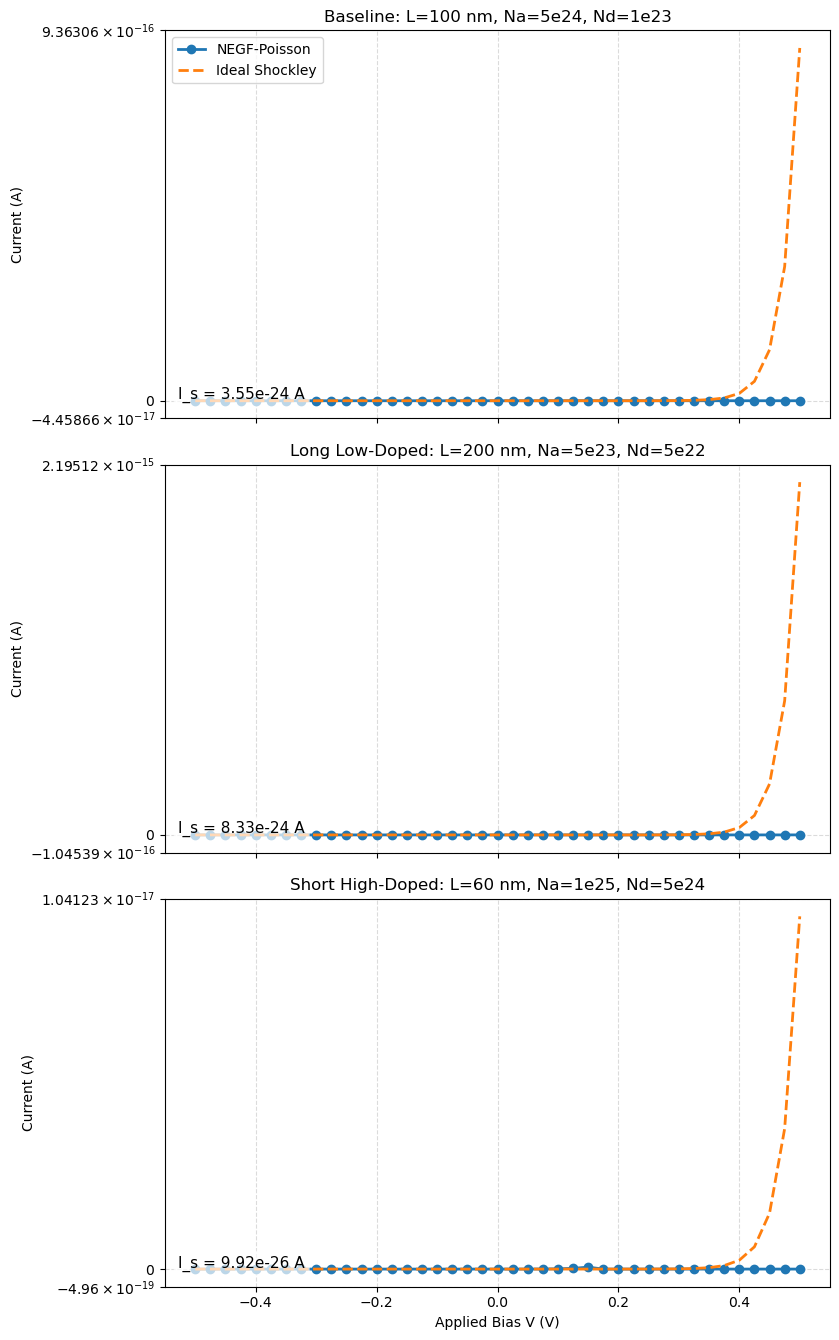

In [8]:
if not pn_results:
    raise RuntimeError("Run the configuration sweep cell before plotting results.")

fig, axes = plt.subplots(len(pn_results), 1, figsize=(8.5, 4.5 * len(pn_results)), sharex=True)
axes = np.atleast_1d(axes)

for ax, result in zip(axes, pn_results):
    V = result["voltages"]
    I_sim = result["current_sim"]
    I_ideal = result["current_ideal"]
    ax.plot(V, I_sim, marker="o", linewidth=2, label="NEGF-Poisson")
    ax.plot(V, I_ideal, linestyle="--", linewidth=2, label="Ideal Shockley")
    ax.set_ylabel("Current (A)")
    ax.set_title(result["label"])
    ax.set_yscale("symlog", linthresh=1e-6)
    ax.grid(True, linestyle="--", alpha=0.45)
    I_s = result["I_s"]
    ax.text(0.02, 0.05, f"I_s = {I_s:.2e} A", transform=ax.transAxes, fontsize=11,
            bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.7, "edgecolor": "none"})

axes[-1].set_xlabel("Applied Bias V (V)")
axes[0].legend(loc="upper left")
fig.tight_layout()
plt.show()

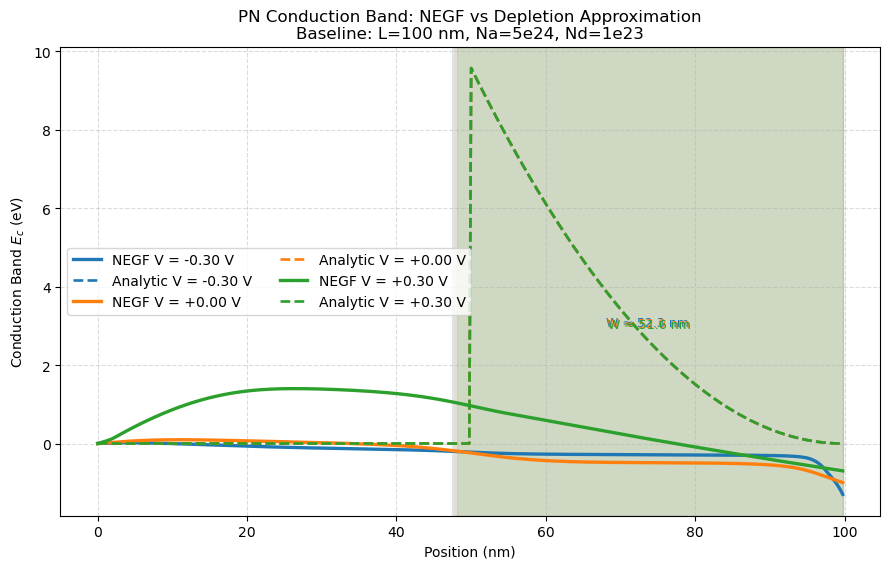

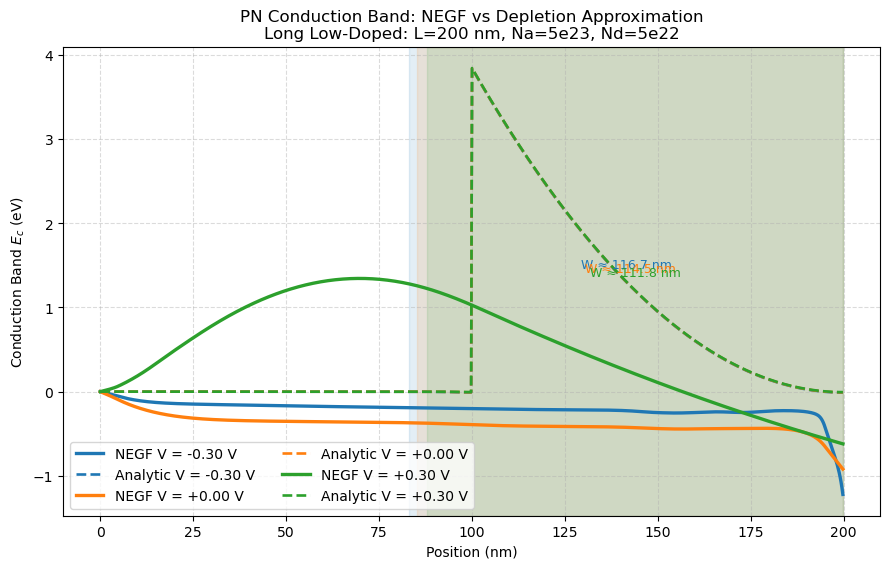

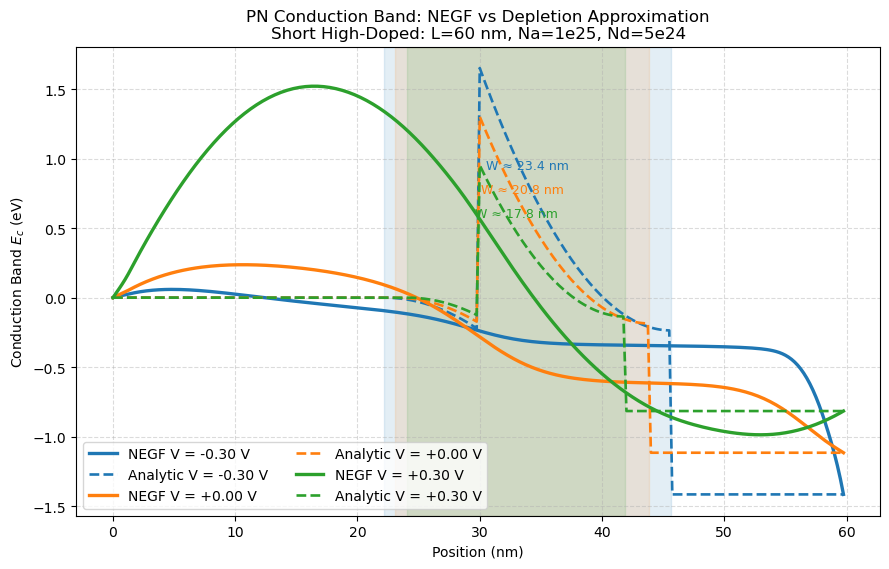

In [9]:
def analytic_depletion_widths(ds, barrier_voltage):
    q = ds.q
    eps = ds.epsl
    Na = max(ds.Na_bulk, 1e10)
    Nd = max(ds.Nd_bulk, 1e10)
    barrier_voltage = max(barrier_voltage, 0.0)
    denom = q * (Na + Nd)
    xp = np.sqrt(max(2.0 * eps * barrier_voltage * Nd / (Na * denom), 0.0))
    xn = np.sqrt(max(2.0 * eps * barrier_voltage * Na / (Nd * denom), 0.0))
    return xp, xn


def analytic_conduction_band(ds, applied_bias):
    x = ds.x.copy()
    x_rel = x - x[ds.junction_index]
    barrier = ds.phi_bi - applied_bias
    barrier = max(barrier, 0.0)
    xp, xn = analytic_depletion_widths(ds, barrier)
    left_extent = x[ds.junction_index] - x[0]
    right_extent = x[-1] - x[ds.junction_index]
    xp_eff = min(xp, left_extent)
    xn_eff = min(xn, right_extent)
    q = ds.q
    eps = ds.epsl
    Na = max(ds.Na_bulk, 1e10)
    Nd = max(ds.Nd_bulk, 1e10)
    phi_profile = np.zeros_like(x_rel)
    phi_peak = 0.0
    if barrier > 0.0:
        phi_peak = 0.5 * q * Nd / eps * xp_eff**2
        right_peak = phi_peak
        if xn_eff > 0.0:
            right_peak = barrier if xn_eff == xn else barrier * (xn_eff / xn if xn > 0 else 1.0)
        phi_peak = min(phi_peak, barrier, right_peak)
    if barrier <= 1e-12:
        phi_profile[:] = np.linspace(0.0, applied_bias, x_rel.size)
    else:
        for idx, xr in enumerate(x_rel):
            if xr <= -xp_eff:
                phi_profile[idx] = 0.0
            elif xr < 0.0:
                term = xr + xp_eff
                phi_profile[idx] = 0.5 * q * Nd / eps * term**2
            elif xr <= xn_eff:
                term = xn_eff - xr
                phi_profile[idx] = phi_peak - 0.5 * q * Na / eps * term**2
            else:
                phi_profile[idx] = barrier
    Ec_eV = -phi_profile
    return x * 1e9, Ec_eV, xp_eff * 1e9, xn_eff * 1e9, -barrier


selected_biases = [-0.3, 0.0, 0.3]
for result in pn_results:
    ds = result["ds"]
    positions_nm = ds.x * 1e9
    fig, ax = plt.subplots(figsize=(9.0, 5.8))
    for bias in selected_biases:
        bias_idx = int(np.argmin(np.abs(ds.Vds - bias)))
        simulated_bias = float(ds.Vds[bias_idx])
        Ec_sim = ds.EEc[bias_idx, 0, :] / ds.q
        sim_line, = ax.plot(positions_nm, Ec_sim, linewidth=2.4, label=f"NEGF V = {simulated_bias:+.2f} V")
        color = sim_line.get_color()
        pos_analytic, Ec_analytic, xp_nm, xn_nm, barrier_energy = analytic_conduction_band(ds, simulated_bias)
        ax.plot(pos_analytic, Ec_analytic, linestyle="--", linewidth=1.9, color=color,
                label=f"Analytic V = {simulated_bias:+.2f} V")
        junction_pos = positions_nm[ds.junction_index]
        left_edge = max(junction_pos - xp_nm, positions_nm[0])
        right_edge = min(junction_pos + xn_nm, positions_nm[-1])
        if right_edge > left_edge:
            ax.axvspan(left_edge, right_edge, color=color, alpha=0.12)
            annotate_y = np.interp((left_edge + right_edge) / 2.0, pos_analytic, Ec_analytic)
            ax.annotate(
                f"W ≈ {max(xp_nm + xn_nm, 0.0):.1f} nm",
                xy=((left_edge + right_edge) / 2.0, annotate_y),
                xytext=(0, 8),
                textcoords="offset points",
                color=color,
                ha="center",
                va="bottom",
                fontsize=9,
            )
    ax.set_xlabel("Position (nm)")
    ax.set_ylabel("Conduction Band $E_c$ (eV)")
    ax.set_title(f"PN Conduction Band: NEGF vs Depletion Approximation\n{result['label']}")
    ax.grid(True, linestyle="--", alpha=0.45)
    ax.legend(ncol=2)
    fig.tight_layout()
    plt.show()

In [10]:
for result in pn_results:
    ds = result["ds"]
    left_nm, right_nm, width_nm = compute_depletion_edges(ds, 0.0)
    print(f"{result['label']}")
    print(f"  Built-in potential: {ds.phi_bi:.3f} V")
    print(f"  Zero-bias depletion width: {width_nm:.1f} nm (from {left_nm:.1f} nm to {right_nm:.1f} nm)")
    print(f"  Saturation current (analytic): {result['I_s']:.3e} A")
    print("-")

Baseline: L=100 nm, Na=5e24, Nd=1e23
  Built-in potential: 0.997 V
  Zero-bias depletion width: 114.7 nm (from 47.8 nm to 99.8 nm)
  Saturation current (analytic): 3.553e-24 A
-
Long Low-Doped: L=200 nm, Na=5e23, Nd=5e22
  Built-in potential: 0.920 V
  Zero-bias depletion width: 161.8 nm (from 85.3 nm to 199.8 nm)
  Saturation current (analytic): 8.330e-24 A
-
Short High-Doped: L=60 nm, Na=1e25, Nd=5e24
  Built-in potential: 1.116 V
  Zero-bias depletion width: 20.8 nm (from 23.1 nm to 43.9 nm)
  Saturation current (analytic): 9.925e-26 A
-
